In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from wave_propagation import *

# 3. Wave propagation
_Kevin Vonk, s1706896, Mar - Apr 2020_

### Section 1: A square barrier

#### a)

Text(0.5, 1.0, 'Error in transfer matrix algorithm')

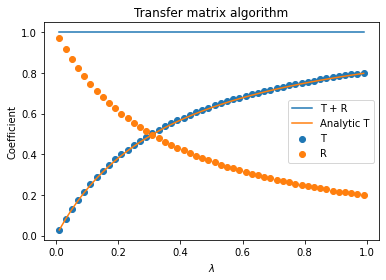

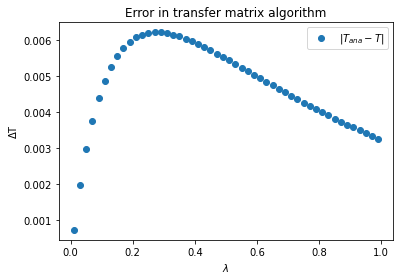

In [2]:
pot = Potential(-0.5, 0.5, 100, expr = lambda y: 1)
lambda_ = np.linspace(0.01, 0.99, 50)

T = []
R = []

for l in lambda_:
    tf = TransferMatrix(pot, l)
    T.append(tf.transmission())
    R.append(tf.reflection())
    
plt.scatter(lambda_, T, label="T")
plt.scatter(lambda_, R, label="R")
plt.plot(lambda_, [i + j for i, j in zip(T, R)], label="T + R")
plt.plot(lambda_, T_ana(lambda_), label="Analytic T")
plt.xlabel(r"$\lambda$")
plt.ylabel("Coefficient")
plt.title("Transfer matrix algorithm")
plt.legend()

plt.figure()
plt.scatter(lambda_, np.abs(T_ana(lambda_) - T), label=r"$| T_{ana} - T |$")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\Delta$T")
plt.legend()
plt.title("Error in transfer matrix algorithm")

From the first plot we can see that the analytic and computed transmissions are quite close together. The reflection and transmission coefficients sum to 1 as expected.

Looking at the error plot, we see that the accuracy is roughly $10^{-2}$.

#### b)

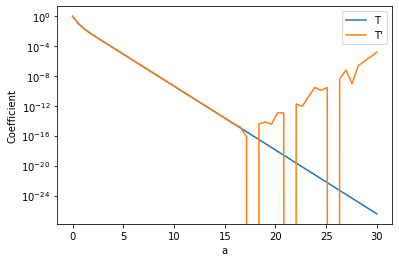

In [3]:
lambda_ = 0.01
A = np.linspace(0, 30, 50)

T = []
Tp = []

for a in A:
    pot = Potential(-0.5*a, 0.5*a, 100, expr = lambda y: 1)
    tf = TransferMatrix(pot, lambda_)
    
    T.append(tf.transmission())
    Tp.append(tf.transmission(dir="left"))
    
plt.semilogy(A, T, label="T")
plt.semilogy(A, Tp, label="T'")
plt.xlabel("a")
plt.ylabel("Coefficient")
plt.legend()

As we can see from the plot above, a numerical instability occurs when calculating T' when the barrier thickness a becomes too large. If the numeric solution were to be accurate, one would expect T and T' to be identical. This is because the properties of a medium are independent of the directionality of the incoming wave in this case.

The reason that this numerical instability occurs has to do with the way a computer stores numbers. Decimal numbers are stored as floats: floating point numbers. On a 64-bit machine, 52 bits are used to store the fraction, 11 bits for the exponent and 1 bit for the sign, resulting in the following expression for the number:

\begin{equation}
    n = (-1)^{\text{sign}} * \text{fraction} * 10^{\text{exponent}}
\end{equation}
(The actual number conversion is slightly different from the representation here given IEEE 754, but that is beyond the scope of this report.)

Because we have a finite amount of bits to represent every number, we cannot represent every number exactly. This results in a grid or a number line of values we can actually represent. For example, say that a float can represent every $0,1n$ steps, where $n \in \mathbb{Z}$. If we want to have the number $0,17$ represented in this system, it must be rounded up to $0,2$ in order to be stored.

This problem compounds itself when doing arithmatic upon two floats. If the exponents are similar in their orders of magnitude, the accuracy lost due to floating point rounding errors is limited. However, if there is too much variation in the exponents, the largest one will take precedence. In order for arithmatic to occur, the float with the smaller exponent must realign itself onto the grid of the larger exponent. In the worst case, the closest point to which the float can align is zero, and thus the smaller float is lost completely in the arithmatic operation.

This problem then is what we see in the figure above. The coefficients become smaller and smaller, up to a point where there simply aren't enough bits of accuracy to complete the arithmatic "correctly" (floating point math is never really "correct", it is always an approximation). Since we only have 11 bits of exponent accuracy, it is fairly easy to run into this problem.

#### c)

As a sanity check, let us first compare the results of 1a) to our scattering matrix result. If everything has gone well, the results should be the same.

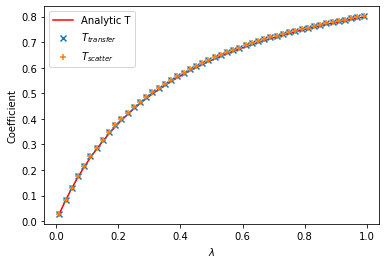

In [4]:
pot = Potential(-0.5, 0.5, 100, expr = lambda y: 1)
lambda_ = np.linspace(0.01, 0.99, 50)

Tt = []
Ts = []

for l in lambda_:
    tm = TransferMatrix(pot, l)
    sm = ScatterMatrix(pot, l)
    Tt.append(tm.transmission())
    Ts.append(sm.transmission())

plt.plot(lambda_, T_ana(lambda_), "-r", label="Analytic T", zorder=-100)
plt.scatter(lambda_, Tt, label=r"$T_{transfer}$", marker="x")
plt.scatter(lambda_, Ts, label=r"$T_{scatter}$", marker="+")
plt.xlabel(r"$\lambda$")
plt.ylabel("Coefficient")
plt.legend()

From the figure above we can deduce that the results of the scattering matrix line up with the results of both the transfer matrix algorithm and the analytic expression. Now then, let us redo the experiment of 1b) with the scattering matrix.

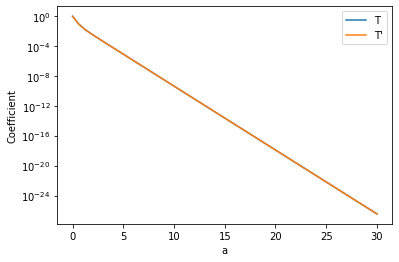

In [5]:
lambda_ = 0.01
A = np.linspace(0, 30, 50)

T = []
Tp = []

for a in A:
    pot = Potential(-0.5*a, 0.5*a, 100, expr = lambda y: 1)
    sm = ScatterMatrix(pot, lambda_)
    
    T.append(sm.transmission())
    Tp.append(sm.transmission(dir="left"))
    
plt.semilogy(A, T, label="T")
plt.semilogy(A, Tp, label="T'")
plt.xlabel("a")
plt.ylabel("Coefficient")
plt.legend()

Using the scattering matrix, the numeric stability is preserved and the transmission coefficient from either direction is identical. The reason that we do not see the floating point rounding errors in $T'$ here, is simply because propagation from the left and from the right are treated as equal, instead of forced to originate from one direction.

#### d)

Taking the code from 1b) and setting $\lambda = 0,5$:

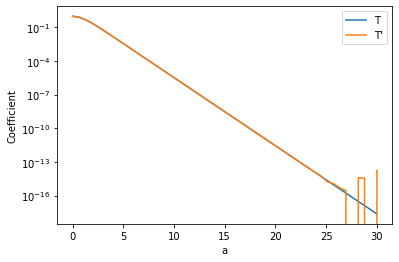

In [6]:
lambda_ = 0.5
A = np.linspace(0, 30, 50)

T = []
Tp = []

for a in A:
    pot = Potential(-0.5*a, 0.5*a, 100, expr = lambda y: 1)
    tf = TransferMatrix(pot, lambda_)
    
    T.append(tf.transmission())
    Tp.append(tf.transmission(dir="left"))
    
plt.semilogy(A, T, label="T")
plt.semilogy(A, Tp, label="T'")
plt.xlabel("a")
plt.ylabel("Coefficient")
plt.legend()

Whilst not as pronounced as in the case of 1b), there still exists a numerical instability when using the transfer matrix for increased barrier thickness. The reason for the instability occuring at a larger thickness compared to 1b) is because there is more energy for the wave to propagate through the barrier, meaning that the decrease in the transmission coefficient is less drastic. However, once we near the region where we do not have enough bits of accuracy, we start seeing the numerical instability yet again.

All in all, the scattering matrix algorithm seems like the more stable algorithm. Furthermore, it is not less accurate than the transfer matrix algorithm in areas where the numerical stability of the transfer matrix is a non-issue. Additionally, the numerical complexity O is the same order for both algorithms. Hence, I recommend the scattering matrix algorithm over the transfer matrix algorithm.

### Section 2: A distorted barrier
#### a)

At y_grid = 15 the transmission T = 0.7104116309427764 has converged to within 1e-05


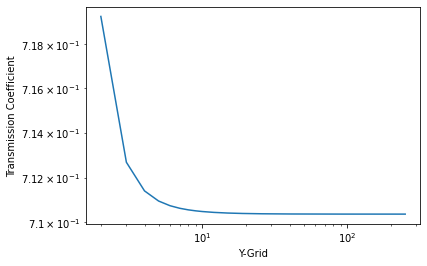

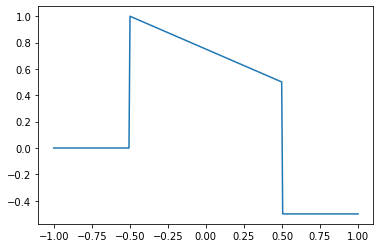

In [11]:
V1 = 1
a = 1
dV = 0.5
lambda_ = 0.5
epsilon = dV / a
conv = 10**-5

start = 2
end = start + 250

T = []

for grid in range(start, end):
    pot = Potential(-0.5*a, 0.5*a, grid, \
                   expr = lambda y: V1 - epsilon * (y + 0.5*a), \
                   outside_range = (lambda _: 0, lambda _: -epsilon * a))
    sm = ScatterMatrix(pot, lambda_)
    sm.midpoint = True
    
    T.append(sm.transmission())
    
conv_keys = [i for i, _ in enumerate(T[:-1]) if int(round(T[i] / conv)) == int(round(T[i+1] / conv))]
print(f"At y_grid = {conv_keys[0] + start} the transmission T = {T[conv_keys[0]]} has converged to within {conv}")

plt.loglog(range(start, end), T)
plt.xlabel("Y-Grid")
plt.ylabel("Transmission Coefficient")
plt.figure()
plt.plot(np.linspace(-1, 1, 300), [pot[i] for i in np.linspace(-1, 1, 300)])

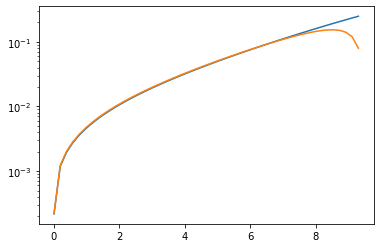

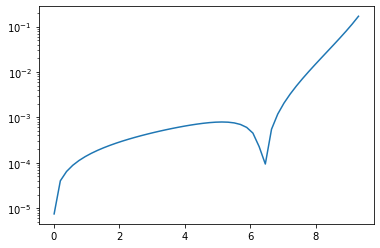

In [13]:
V1 = 10
a = 1
dV = 0.5
epsilon = dV / a

lambda_ = np.linspace(0.01, V1-dV, 50, endpoint=False)

T = []
Twkb = []

for l in lambda_:
    pot = Potential(-0.5*a, 0.5*a, 100, \
                    expr = lambda y: V1 - epsilon * (y + 0.5*a), \
                    outside_range = (lambda _: 0, lambda _: -epsilon * a))
    sm = ScatterMatrix(pot, l)
    sm.midpoint = True
    
    T.append(sm.transmission())
    Twkb.append(sm.T_wkb(lambda lam: (16*lam*(V1-dV-lam))/V1**2))

plt.semilogy(lambda_, T)
plt.semilogy(lambda_, Twkb)
plt.figure()
plt.semilogy(lambda_, np.abs(np.array(T)-np.array(Twkb)))